In [13]:
import numpy as np
import matplotlib.pyplot as plt
# from torchAA import torchAA
# from torchNMF import NMF
import pandas as pd

In [14]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 5, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)

def lorentz(mu, s, time):
    return 1/np.pi*s/((time-mu)**2+s**2)

def duplet(f, mu, s, time, peak_s):
    return f(mu, s, time) + f(mu+peak_s, s, time)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V

np.random.seed(42)

# Random mixings:
W = np.random.dirichlet(np.ones(d), N)
# W = np.append(W, [[1,0,0]], axis=0)
# W = np.append(W, [[0,1,0]], axis=0)
# W = np.append(W, [[0,0,1]], axis=0)
# N = N+3

#W = np.random.rand(N, d)
shift = 400
# Random gaussian shifts
tau = np.random.randint(-shift, shift, size=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [100, 400, 800]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
H_lorentz = np.array([lorentz(m, s, t) for m, s in list(zip(mean, std))])
H_duplet = np.array([duplet(gauss, m, s, t, 50) for m, s in list(zip(mean, std))])

X = shift_dataset(W, H, tau)
X_lorentz = shift_dataset(W, H_lorentz, tau)
X_duplet = shift_dataset(W, H_duplet, tau)


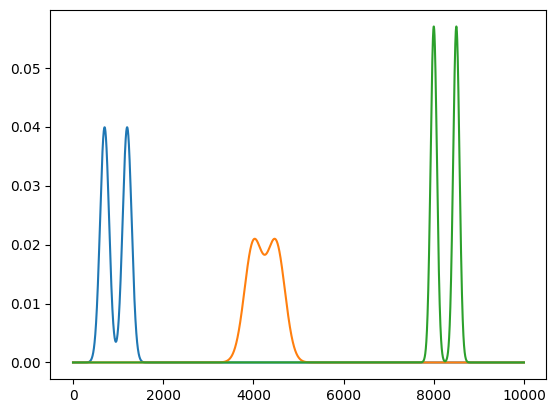

In [15]:
plt.plot(H_duplet.T)
# plt.plot(H_lorentz.T)
# plt.show()
plt.show()

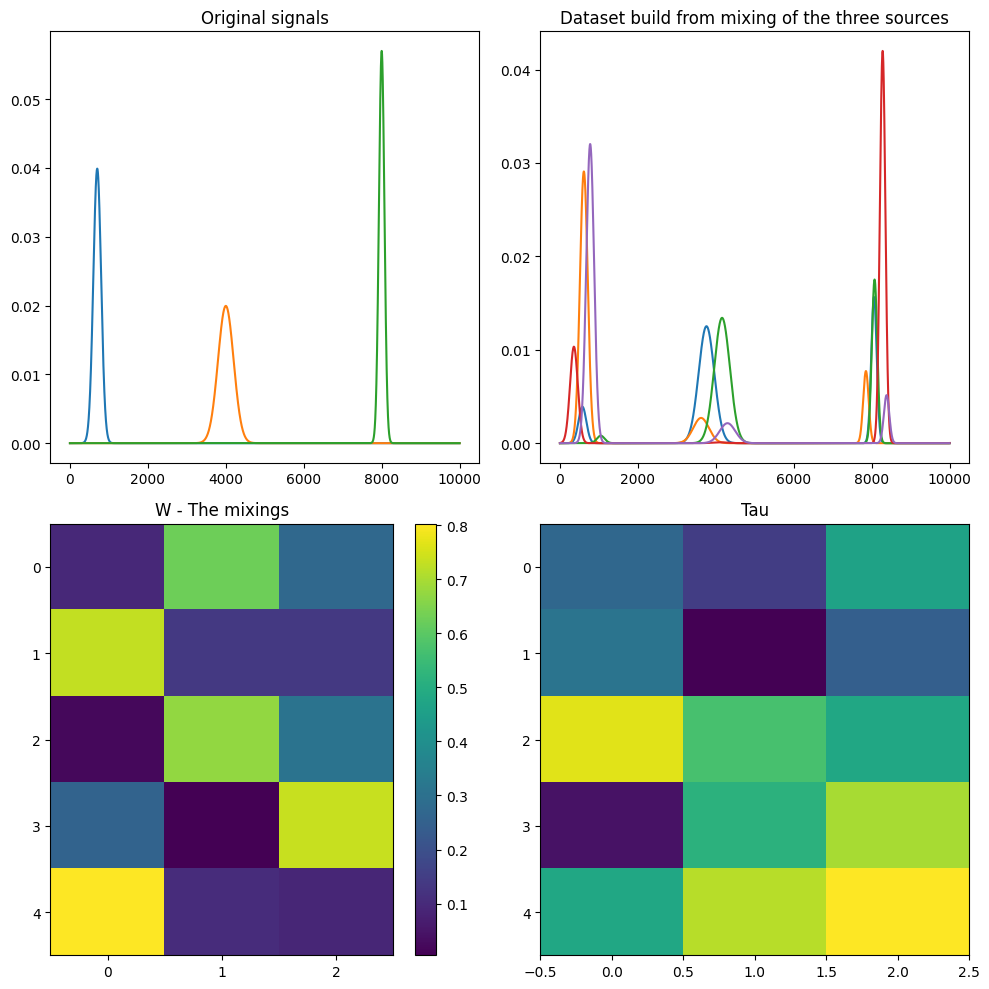

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot original signals
for signal in H:
    axs[0, 0].plot(signal)
axs[0, 0].set_title("Original signals")

# Plot dataset built from mixing of the three sources
for signal in X:
    axs[0, 1].plot(signal.real)
axs[0, 1].set_title("Dataset build from mixing of the three sources")

# Plot W - The mixings
im = axs[1, 0].imshow(W, aspect='auto', interpolation="none")
fig.colorbar(im, ax=axs[1, 0])
axs[1, 0].set_xticks(np.arange(0, d, 1))
axs[1, 0].set_yticks(np.arange(0, N, 1))
axs[1, 0].set_title("W - The mixings")

# Plot tau
axs[1, 1].imshow(tau, aspect='auto', interpolation="none")
axs[1, 1].set_title("Tau")

plt.tight_layout()
plt.show()

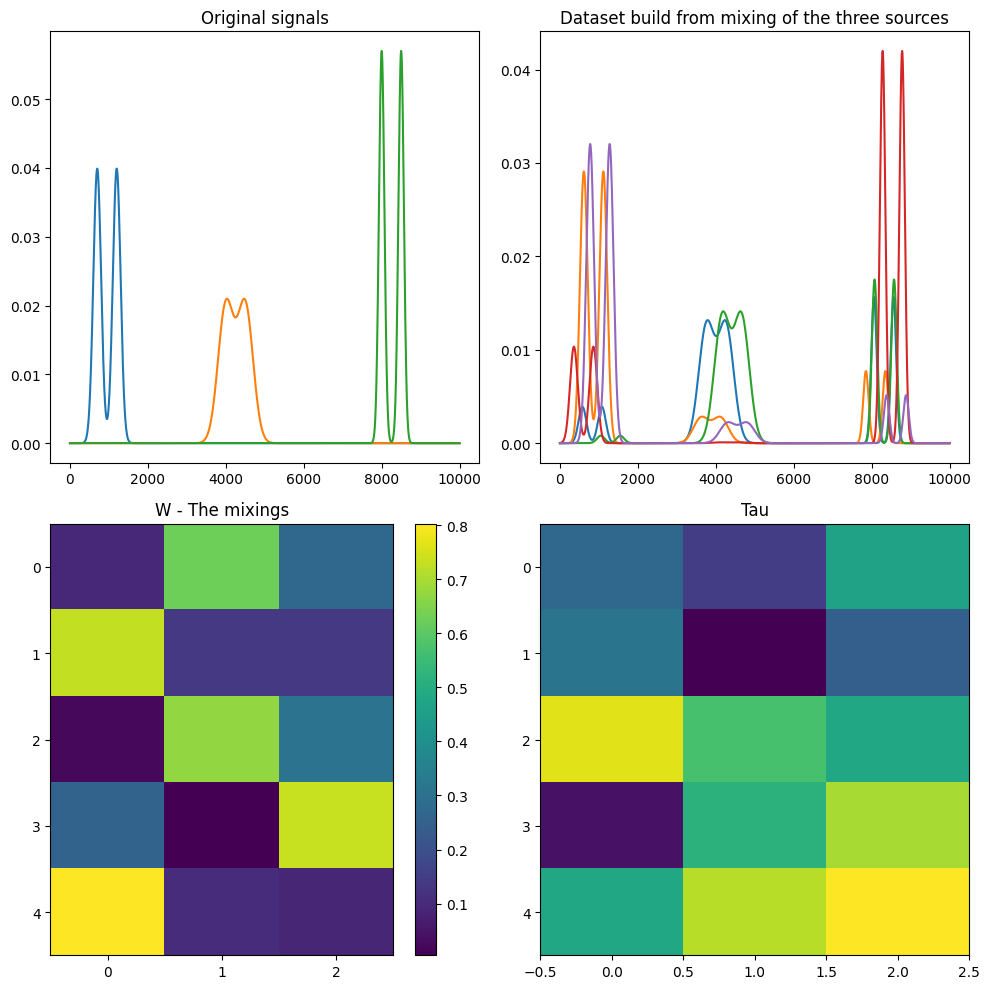

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot original signals
for signal in H_duplet:
    axs[0, 0].plot(signal)
axs[0, 0].set_title("Original signals")

# Plot dataset built from mixing of the three sources
for signal in X_duplet:
    axs[0, 1].plot(signal.real)
axs[0, 1].set_title("Dataset build from mixing of the three sources")

# Plot W - The mixings
im = axs[1, 0].imshow(W, aspect='auto', interpolation="none")
fig.colorbar(im, ax=axs[1, 0])
axs[1, 0].set_xticks(np.arange(0, d, 1))
axs[1, 0].set_yticks(np.arange(0, N, 1))
axs[1, 0].set_title("W - The mixings")

# Plot tau
axs[1, 1].imshow(tau, aspect='auto', interpolation="none")
axs[1, 1].set_title("Tau")

plt.tight_layout()
plt.show()

In [18]:
#save X_duplet and X as a csv file
X_duplet_df = pd.DataFrame(X_duplet.real)
X_duplet_df.to_csv('X_duplet.csv', index=False, header=False)

X_df = pd.DataFrame(X.real)
X_df.to_csv('X.csv', index=False, header=False)